# Analiza predykcyjna danych Credit

## Cel
Znalezienie modeli o możliwie największej skuteczności dla:
- **a)** Przewidywania czy dochód > 50 (klasyfikacja)
- **b)** Przewidywania liczby kart kredytowych (regresja)

Wykorzystamy różne modele: regresję logistyczną, drzewa decyzyjne, lasy losowe, k-NN z walidacją krzyżową (KFold).

## 1. Import bibliotek i wczytanie danych

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Ustawienia wizualizacji
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Biblioteki zaimportowane pomyślnie!")

Biblioteki zaimportowane pomyślnie!


In [2]:
# Wczytanie danych
df = pd.read_csv('data/Credit.csv', index_col=0)

print("Kształt danych:", df.shape)
print("\nPierwsze wiersze:")
df.head()

Kształt danych: (400, 11)

Pierwsze wiersze:


,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
1,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333
2,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903
3,104.593,7075,514,4,71,11,Male,No,No,Asian,580
4,148.924,9504,681,3,36,11,Female,No,No,Asian,964
5,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331


In [3]:
# Informacje o danych
print("Informacje o zbiorze danych:")
print(df.info())
print("\n" + "="*50)
print("\nStatystyki opisowe:")
df.describe()

Informacje o zbiorze danych:
<class 'pandas.core.frame.DataFrame'>
Index: 400 entries, 1 to 400
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Income     400 non-null    float64
 1   Limit      400 non-null    int64  
 2   Rating     400 non-null    int64  
 3   Cards      400 non-null    int64  
 4   Age        400 non-null    int64  
 5   Education  400 non-null    int64  
 6   Gender     400 non-null    object 
 7   Student    400 non-null    object 
 8   Married    400 non-null    object 
 9   Ethnicity  400 non-null    object 
 10  Balance    400 non-null    int64  
dtypes: float64(1), int64(6), object(4)
memory usage: 37.5+ KB
None


Statystyki opisowe:


,Income,Limit,Rating,Cards,Age,Education,Balance
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,45.218885,4735.600000,354.940000,2.957500,55.667500,13.450000,520.015000
std,35.244273,2308.198848,154.724143,1.371275,17.249807,3.125207,459.758877
min,10.354000,855.000000,93.000000,1.000000,23.000000,5.000000,0.000000
25%,21.007250,3088.000000,247.250000,2.000000,41.750000,11.000000,68.750000
50%,33.115500,4622.500000,344.000000,3.000000,56.000000,14.000000,459.500000
75%,57.470750,5872.750000,437.250000,4.000000,70.000000,16.000000,863.000000
max,186.634000,13913.000000,982.000000,9.000000,98.000000,20.000000,1999.000000


## 2. Przygotowanie danych

### 2.1. Zadanie a) - Przewidywanie czy Income > 50
Tworzymy zmienną indykatorową i przygotowujemy dane do klasyfikacji.

In [4]:
# Przygotowanie danych dla zadania a) - klasyfikacja Income > 50
df_classification = df.copy()

# Tworzymy zmienną indykatorową
df_classification['HighIncome'] = (df_classification['Income'] > 50).astype(int)

# Usuwamy oryginalną zmienną Income
df_classification = df_classification.drop('Income', axis=1)

print("Rozkład zmiennej docelowej HighIncome:")
print(df_classification['HighIncome'].value_counts())
print(f"\nProporcje: {df_classification['HighIncome'].value_counts(normalize=True)}")

# Kodowanie zmiennych kategorycznych
le = LabelEncoder()
categorical_cols = ['Gender', 'Student', 'Married', 'Ethnicity']

for col in categorical_cols:
    df_classification[col] = le.fit_transform(df_classification[col].astype(str))

# Przygotowanie X i y
X_a = df_classification.drop('HighIncome', axis=1)
y_a = df_classification['HighIncome']

print(f"\nKształt X: {X_a.shape}")
print(f"Kształt y: {y_a.shape}")

Rozkład zmiennej docelowej HighIncome:
HighIncome
0    276
1    124
Name: count, dtype: int64

Proporcje: HighIncome
0    0.69
1    0.31
Name: proportion, dtype: float64

Kształt X: (400, 10)
Kształt y: (400,)


### 2.2. Zadanie b) - Przewidywanie liczby kart kredytowych
Przygotowujemy dane do regresji.

In [5]:
# Przygotowanie danych dla zadania b) - regresja liczby kart
df_regression = df.copy()

# Kodowanie zmiennych kategorycznych
for col in categorical_cols:
    df_regression[col] = le.fit_transform(df_regression[col].astype(str))

# Przygotowanie X i y
X_b = df_regression.drop('Cards', axis=1)
y_b = df_regression['Cards']

print("Rozkład zmiennej docelowej Cards:")
print(y_b.value_counts().sort_index())
print(f"\nStatystyki opisowe Cards:")
print(y_b.describe())

Rozkład zmiennej docelowej Cards:
Cards
1     51
2    115
3    111
4     72
5     34
6     11
7      4
8      1
9      1
Name: count, dtype: int64

Statystyki opisowe Cards:
count    400.000000
mean       2.957500
std        1.371275
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        9.000000
Name: Cards, dtype: float64


## 3. Zadanie a) - Modele klasyfikacyjne (Income > 50)

### 3.1. Konfiguracja modeli i walidacji krzyżowej

In [6]:
# Standaryzacja danych
scaler = StandardScaler()
X_a_scaled = scaler.fit_transform(X_a)

# Konfiguracja walidacji krzyżowej
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

# Definicja modeli klasyfikacyjnych z różnymi parametrami
classification_models = {
    # Regresja logistyczna
    'Logistic Regression (C=0.1)': LogisticRegression(C=0.1, max_iter=1000, random_state=42),
    'Logistic Regression (C=1.0)': LogisticRegression(C=1.0, max_iter=1000, random_state=42),
    'Logistic Regression (C=10)': LogisticRegression(C=10, max_iter=1000, random_state=42),
    
    # Drzewa decyzyjne
    'Decision Tree (depth=3)': DecisionTreeClassifier(max_depth=3, random_state=42),
    'Decision Tree (depth=5)': DecisionTreeClassifier(max_depth=5, random_state=42),
    'Decision Tree (depth=10)': DecisionTreeClassifier(max_depth=10, random_state=42),
    'Decision Tree (depth=None)': DecisionTreeClassifier(max_depth=None, random_state=42),
    
    # Lasy losowe
    'Random Forest (n=50, depth=5)': RandomForestClassifier(n_estimators=50, max_depth=5, random_state=42),
    'Random Forest (n=100, depth=10)': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42),
    'Random Forest (n=100, depth=None)': RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42),
    'Random Forest (n=200, depth=None)': RandomForestClassifier(n_estimators=200, max_depth=None, random_state=42),
    
    # k-NN
    'KNN (k=3)': KNeighborsClassifier(n_neighbors=3),
    'KNN (k=5)': KNeighborsClassifier(n_neighbors=5),
    'KNN (k=10)': KNeighborsClassifier(n_neighbors=10),
    'KNN (k=20)': KNeighborsClassifier(n_neighbors=20),
    'KNN (k=30)': KNeighborsClassifier(n_neighbors=30),
}

print(f"Zdefiniowano {len(classification_models)} modeli klasyfikacyjnych")

Zdefiniowano 16 modeli klasyfikacyjnych


### 3.2. Trening i ewaluacja modeli

In [7]:
# Trening i ewaluacja wszystkich modeli klasyfikacyjnych
classification_results = {}

print("Trenowanie modeli klasyfikacyjnych z walidacją krzyżową (10-fold)...\n")

for name, model in classification_models.items():
    # Walidacja krzyżowa
    scores = cross_val_score(model, X_a_scaled, y_a, cv=kfold, scoring='accuracy')
    classification_results[name] = scores
    
    print(f"{name:40s} | Średnia: {scores.mean():.4f} | Std: {scores.std():.4f}")

print("\n" + "="*80)
print("Trening zakończony!")

# Znalezienie najlepszego modelu
best_model_name = max(classification_results, key=lambda k: classification_results[k].mean())
best_score = classification_results[best_model_name].mean()
print(f"\n🏆 NAJLEPSZY MODEL: {best_model_name}")
print(f"   Accuracy: {best_score:.4f} ± {classification_results[best_model_name].std():.4f}")

Trenowanie modeli klasyfikacyjnych z walidacją krzyżową (10-fold)...

Logistic Regression (C=0.1)              | Średnia: 0.8725 | Std: 0.0728
Logistic Regression (C=1.0)              | Średnia: 0.9375 | Std: 0.0437
Logistic Regression (C=10)               | Średnia: 0.9625 | Std: 0.0375
Decision Tree (depth=3)                  | Średnia: 0.8725 | Std: 0.0666
Decision Tree (depth=5)                  | Średnia: 0.9075 | Std: 0.0488
Decision Tree (depth=10)                 | Średnia: 0.9000 | Std: 0.0570
Decision Tree (depth=None)               | Średnia: 0.9025 | Std: 0.0553
Random Forest (n=50, depth=5)            | Średnia: 0.8500 | Std: 0.0680
Random Forest (n=100, depth=10)          | Średnia: 0.9000 | Std: 0.0512
Random Forest (n=100, depth=None)        | Średnia: 0.9025 | Std: 0.0553
Random Forest (n=200, depth=None)        | Średnia: 0.8950 | Std: 0.0610
KNN (k=3)                                | Średnia: 0.7450 | Std: 0.0714
KNN (k=5)                                | Średnia: 0.

### 3.3. Wizualizacja wyników - Box Plot

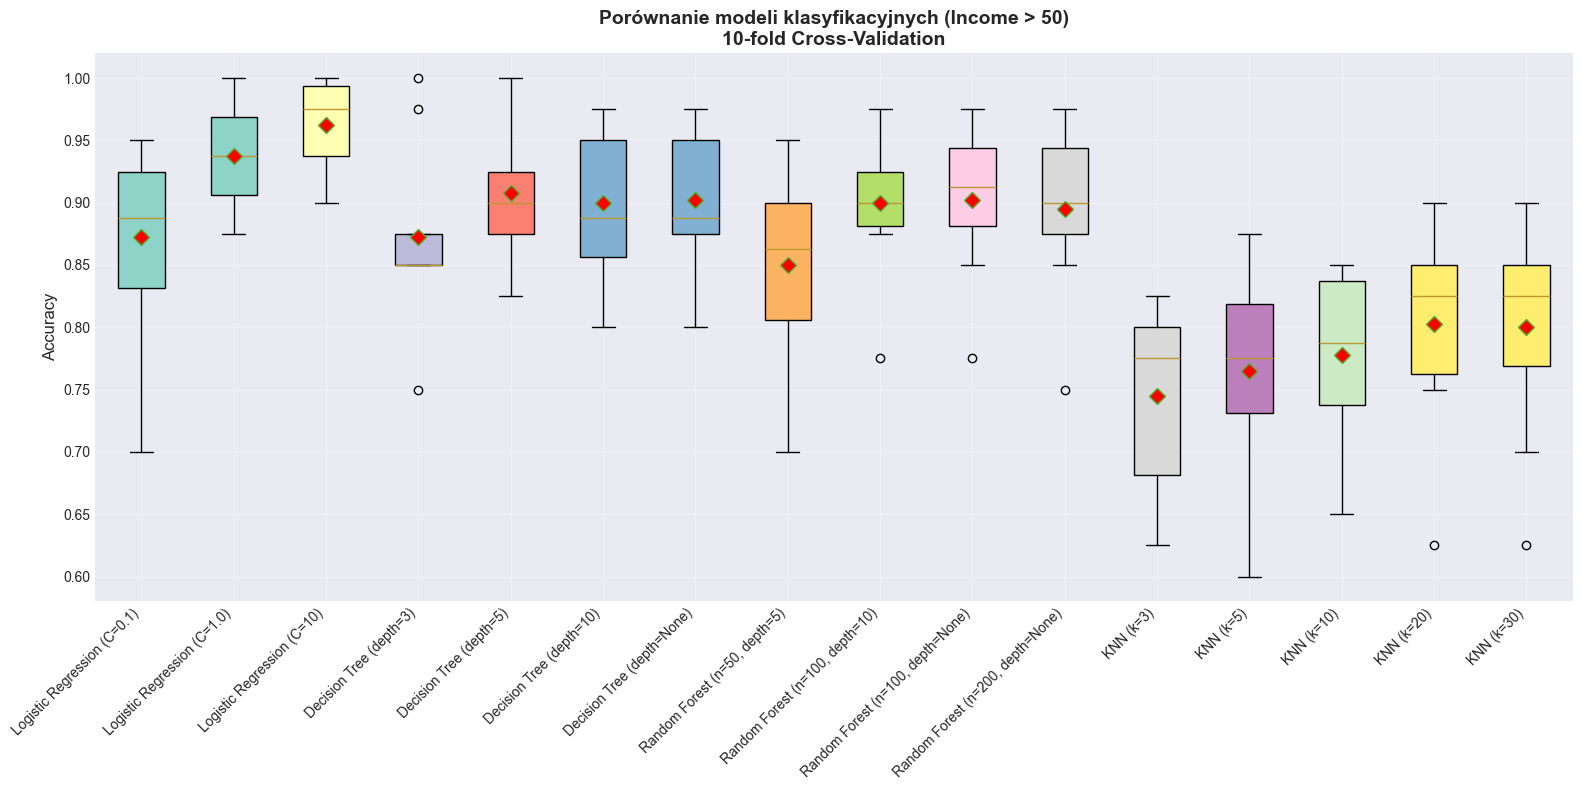


Szczegółowe statystyki modeli klasyfikacyjnych:
                                     mean       std    min    max
Logistic Regression (C=10)         0.9625  0.039528  0.900  1.000
Logistic Regression (C=1.0)        0.9375  0.046022  0.875  1.000
Decision Tree (depth=5)            0.9075  0.051438  0.825  1.000
Decision Tree (depth=None)         0.9025  0.058274  0.800  0.975
Random Forest (n=100, depth=None)  0.9025  0.058274  0.775  0.975
Decision Tree (depth=10)           0.9000  0.060093  0.800  0.975
Random Forest (n=100, depth=10)    0.9000  0.054006  0.775  0.975
Random Forest (n=200, depth=None)  0.8950  0.064334  0.750  0.975
Logistic Regression (C=0.1)        0.8725  0.076784  0.700  0.950
Decision Tree (depth=3)            0.8725  0.070168  0.750  1.000
Random Forest (n=50, depth=5)      0.8500  0.071686  0.700  0.950
KNN (k=20)                         0.8025  0.077683  0.625  0.900
KNN (k=30)                         0.8000  0.083333  0.625  0.900
KNN (k=10)                 

In [8]:
# Przygotowanie danych do wykresu
results_df_a = pd.DataFrame(classification_results)

# Box plot dla wszystkich modeli
plt.figure(figsize=(16, 8))
box_plot = plt.boxplot([classification_results[name] for name in classification_results.keys()],
                        labels=list(classification_results.keys()),
                        patch_artist=True,
                        showmeans=True,
                        meanprops=dict(marker='D', markerfacecolor='red', markersize=8))

# Kolorowanie boxów
colors = plt.cm.Set3(np.linspace(0, 1, len(classification_results)))
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)

plt.xticks(rotation=45, ha='right')
plt.ylabel('Accuracy', fontsize=12)
plt.title('Porównanie modeli klasyfikacyjnych (Income > 50)\n10-fold Cross-Validation', 
          fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Wyświetlenie szczegółowych statystyk
print("\nSzczegółowe statystyki modeli klasyfikacyjnych:")
print("="*90)
summary_stats = results_df_a.describe().T
summary_stats = summary_stats.sort_values('mean', ascending=False)
print(summary_stats[['mean', 'std', 'min', 'max']])

## 4. Zadanie b) - Modele regresyjne (liczba kart kredytowych)

### 4.1. Konfiguracja modeli regresyjnych

In [9]:
# Standaryzacja danych
X_b_scaled = scaler.fit_transform(X_b)

# Definicja modeli regresyjnych - dla zadania regresyjnego użyjemy R² jako metryki
# ale też obliczymy "accuracy" jako procent predykcji dokładnie trafnych
regression_models = {
    # Regresja liniowa z regularyzacją
    'Ridge (alpha=0.1)': Ridge(alpha=0.1, random_state=42),
    'Ridge (alpha=1.0)': Ridge(alpha=1.0, random_state=42),
    'Ridge (alpha=10)': Ridge(alpha=10, random_state=42),
    'Lasso (alpha=0.1)': Lasso(alpha=0.1, random_state=42),
    'Lasso (alpha=1.0)': Lasso(alpha=1.0, random_state=42),
    
    # Drzewa decyzyjne
    'Decision Tree (depth=3)': DecisionTreeRegressor(max_depth=3, random_state=42),
    'Decision Tree (depth=5)': DecisionTreeRegressor(max_depth=5, random_state=42),
    'Decision Tree (depth=10)': DecisionTreeRegressor(max_depth=10, random_state=42),
    'Decision Tree (depth=None)': DecisionTreeRegressor(max_depth=None, random_state=42),
    
    # Lasy losowe
    'Random Forest (n=50, depth=5)': RandomForestRegressor(n_estimators=50, max_depth=5, random_state=42),
    'Random Forest (n=100, depth=10)': RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
    'Random Forest (n=100, depth=None)': RandomForestRegressor(n_estimators=100, max_depth=None, random_state=42),
    'Random Forest (n=200, depth=None)': RandomForestRegressor(n_estimators=200, max_depth=None, random_state=42),
    
    # k-NN
    'KNN (k=3)': KNeighborsRegressor(n_neighbors=3),
    'KNN (k=5)': KNeighborsRegressor(n_neighbors=5),
    'KNN (k=10)': KNeighborsRegressor(n_neighbors=10),
    'KNN (k=20)': KNeighborsRegressor(n_neighbors=20),
    'KNN (k=30)': KNeighborsRegressor(n_neighbors=30),
}

print(f"Zdefiniowano {len(regression_models)} modeli regresyjnych")

Zdefiniowano 18 modeli regresyjnych


### 4.2. Trening i ewaluacja - obliczamy "accuracy" jako % dokładnych trafień

In [10]:
# Funkcja do obliczenia accuracy dla regresji (% dokładnie trafnych wartości)
from sklearn.model_selection import cross_val_predict

def regression_accuracy_cv(model, X, y, cv):
    """
    Oblicza accuracy dla problemu regresyjnego jako procent dokładnie przewidzianych wartości
    """
    accuracies = []
    
    for train_idx, test_idx in cv.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # Zaokrąglamy predykcje do najbliższej liczby całkowitej
        y_pred_rounded = np.round(y_pred).astype(int)
        
        # Obliczamy accuracy
        accuracy = (y_pred_rounded == y_test).mean()
        accuracies.append(accuracy)
    
    return np.array(accuracies)

# Trening i ewaluacja wszystkich modeli regresyjnych
regression_results = {}

print("Trenowanie modeli regresyjnych z walidacją krzyżową (10-fold)...\n")
print("Obliczamy 'accuracy' jako % dokładnie przewidzianych wartości Cards\n")

for name, model in regression_models.items():
    # Obliczamy accuracy
    scores = regression_accuracy_cv(model, X_b_scaled, y_b, kfold)
    regression_results[name] = scores
    
    print(f"{name:40s} | Średnia: {scores.mean():.4f} | Std: {scores.std():.4f}")

print("\n" + "="*80)
print("Trening zakończony!")

# Znalezienie najlepszego modelu
best_model_name_b = max(regression_results, key=lambda k: regression_results[k].mean())
best_score_b = regression_results[best_model_name_b].mean()
print(f"\n🏆 NAJLEPSZY MODEL: {best_model_name_b}")
print(f"   Accuracy: {best_score_b:.4f} ± {regression_results[best_model_name_b].std():.4f}")

Trenowanie modeli regresyjnych z walidacją krzyżową (10-fold)...

Obliczamy 'accuracy' jako % dokładnie przewidzianych wartości Cards

Ridge (alpha=0.1)                        | Średnia: 0.3400 | Std: 0.0515
Ridge (alpha=1.0)                        | Średnia: 0.3000 | Std: 0.0474
Ridge (alpha=10)                         | Średnia: 0.2750 | Std: 0.0500
Lasso (alpha=0.1)                        | Średnia: 0.2775 | Std: 0.0467
Lasso (alpha=1.0)                        | Średnia: 0.2775 | Std: 0.0467
Decision Tree (depth=3)                  | Średnia: 0.2900 | Std: 0.0450
Decision Tree (depth=5)                  | Średnia: 0.2950 | Std: 0.0723
Decision Tree (depth=10)                 | Średnia: 0.2575 | Std: 0.0716
Decision Tree (depth=None)               | Średnia: 0.2375 | Std: 0.0539
Random Forest (n=50, depth=5)            | Średnia: 0.2800 | Std: 0.0828
Random Forest (n=100, depth=10)          | Średnia: 0.3100 | Std: 0.0943
Random Forest (n=100, depth=None)        | Średnia: 0.3050 | S

### 4.3. Wizualizacja wyników - Box Plot

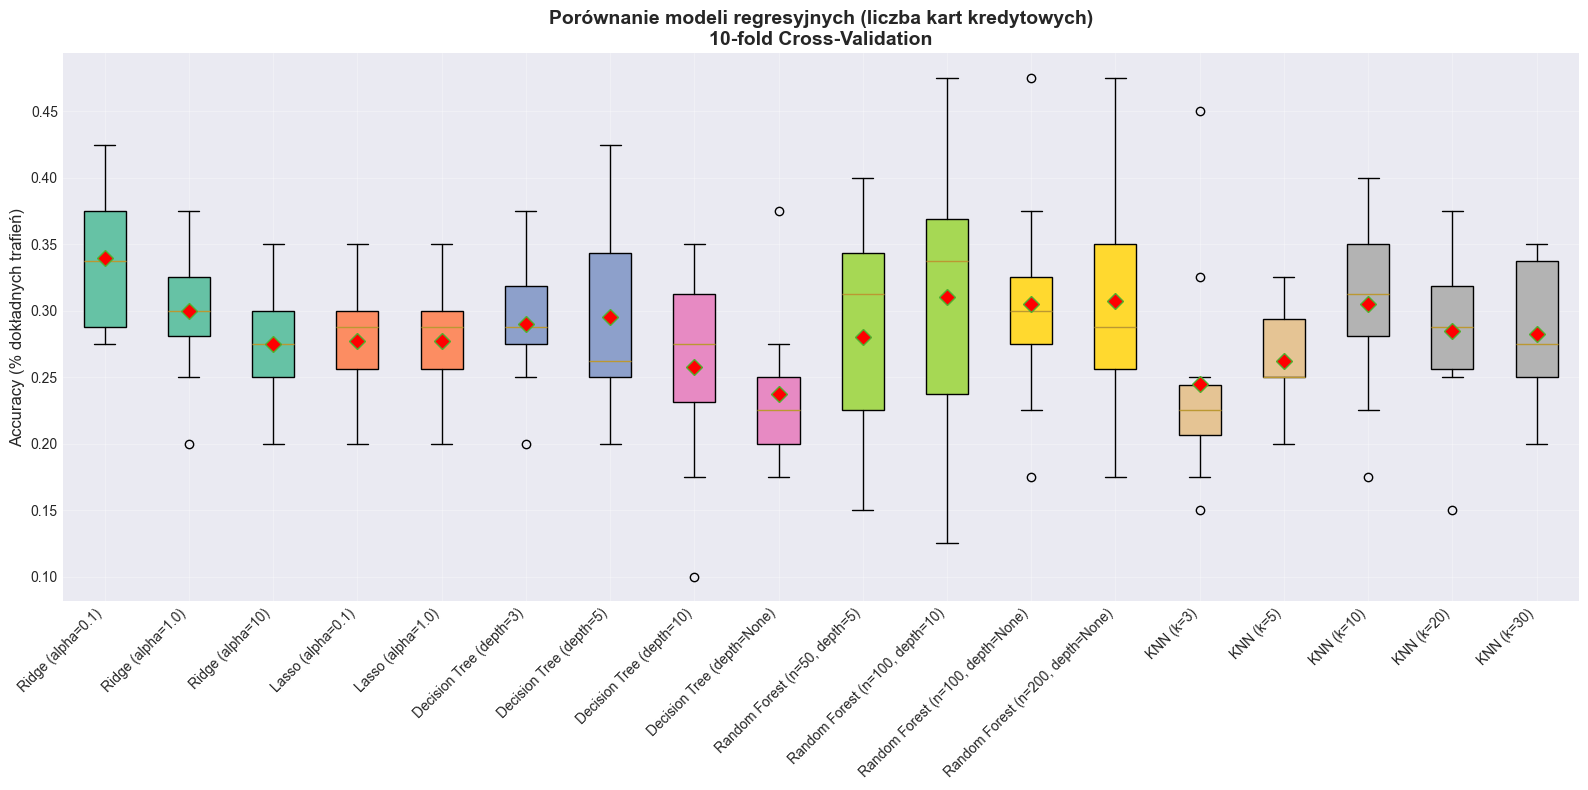


Szczegółowe statystyki modeli regresyjnych:
                                     mean       std    min    max
Ridge (alpha=0.1)                  0.3400  0.054263  0.275  0.425
Random Forest (n=100, depth=10)    0.3100  0.099443  0.125  0.475
Random Forest (n=200, depth=None)  0.3075  0.088231  0.175  0.475
KNN (k=10)                         0.3050  0.066458  0.175  0.400
Random Forest (n=100, depth=None)  0.3050  0.081479  0.175  0.475
Ridge (alpha=1.0)                  0.3000  0.050000  0.200  0.375
Decision Tree (depth=5)            0.2950  0.076194  0.200  0.425
Decision Tree (depth=3)            0.2900  0.047434  0.200  0.375
KNN (k=20)                         0.2850  0.062583  0.150  0.375
KNN (k=30)                         0.2825  0.054070  0.200  0.350
Random Forest (n=50, depth=5)      0.2800  0.087242  0.150  0.400
Lasso (alpha=0.1)                  0.2775  0.049230  0.200  0.350
Lasso (alpha=1.0)                  0.2775  0.049230  0.200  0.350
Ridge (alpha=10)               

In [11]:
# Przygotowanie danych do wykresu
results_df_b = pd.DataFrame(regression_results)

# Box plot dla wszystkich modeli
plt.figure(figsize=(16, 8))
box_plot = plt.boxplot([regression_results[name] for name in regression_results.keys()],
                        labels=list(regression_results.keys()),
                        patch_artist=True,
                        showmeans=True,
                        meanprops=dict(marker='D', markerfacecolor='red', markersize=8))

# Kolorowanie boxów
colors = plt.cm.Set2(np.linspace(0, 1, len(regression_results)))
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)

plt.xticks(rotation=45, ha='right')
plt.ylabel('Accuracy (% dokładnych trafień)', fontsize=12)
plt.title('Porównanie modeli regresyjnych (liczba kart kredytowych)\n10-fold Cross-Validation', 
          fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Wyświetlenie szczegółowych statystyk
print("\nSzczegółowe statystyki modeli regresyjnych:")
print("="*90)
summary_stats_b = results_df_b.describe().T
summary_stats_b = summary_stats_b.sort_values('mean', ascending=False)
print(summary_stats_b[['mean', 'std', 'min', 'max']])

## 5. Porównanie wyników - Podsumowanie

### 5.1. Wykres porównawczy najlepszych modeli

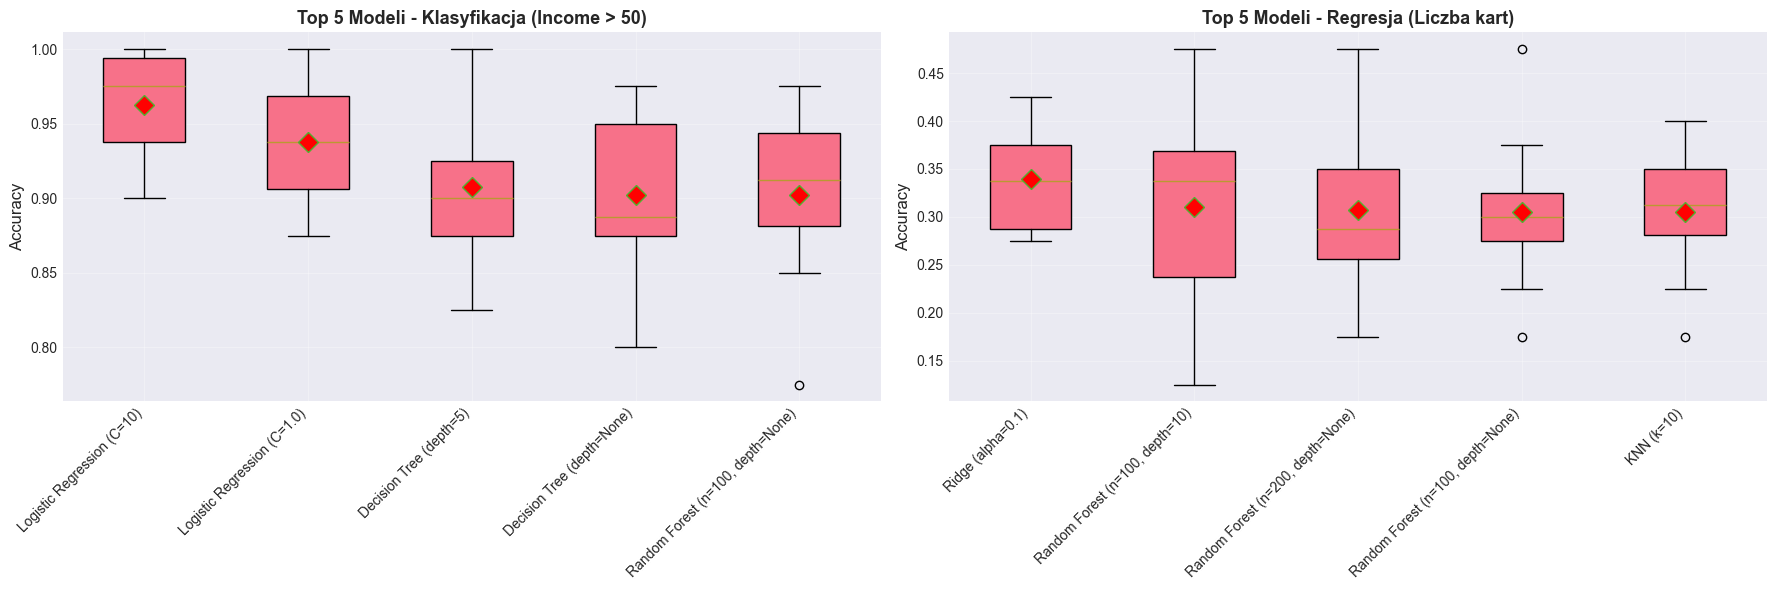

In [12]:
# Wykres porównawczy top 5 modeli dla każdego zadania
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Zadanie a) - Top 5 modeli klasyfikacyjnych
top5_class = sorted(classification_results.items(), key=lambda x: x[1].mean(), reverse=True)[:5]
top5_class_names = [name for name, _ in top5_class]
top5_class_scores = [scores for _, scores in top5_class]

axes[0].boxplot(top5_class_scores, labels=top5_class_names, patch_artist=True, showmeans=True,
                meanprops=dict(marker='D', markerfacecolor='red', markersize=10))
axes[0].set_xticklabels(top5_class_names, rotation=45, ha='right')
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Top 5 Modeli - Klasyfikacja (Income > 50)', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Zadanie b) - Top 5 modeli regresyjnych
top5_reg = sorted(regression_results.items(), key=lambda x: x[1].mean(), reverse=True)[:5]
top5_reg_names = [name for name, _ in top5_reg]
top5_reg_scores = [scores for _, scores in top5_reg]

axes[1].boxplot(top5_reg_scores, labels=top5_reg_names, patch_artist=True, showmeans=True,
                meanprops=dict(marker='D', markerfacecolor='red', markersize=10))
axes[1].set_xticklabels(top5_reg_names, rotation=45, ha='right')
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Top 5 Modeli - Regresja (Liczba kart)', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 5.2. Ostateczne wyniki

In [13]:
print("="*90)
print(" "*30 + "PODSUMOWANIE WYNIKÓW")
print("="*90)

print("\n📊 ZADANIE A) Klasyfikacja - Przewidywanie czy Income > 50")
print("-" * 90)
print(f"🏆 Najlepszy model: {best_model_name}")
print(f"   Accuracy: {best_score:.4f} ({best_score*100:.2f}%)")
print(f"   Odchylenie standardowe: {classification_results[best_model_name].std():.4f}")
print(f"   Przedział: [{classification_results[best_model_name].min():.4f}, {classification_results[best_model_name].max():.4f}]")

print("\n   Top 3 modele:")
for i, (name, scores) in enumerate(sorted(classification_results.items(), 
                                          key=lambda x: x[1].mean(), reverse=True)[:3], 1):
    print(f"   {i}. {name:45s} | Accuracy: {scores.mean():.4f} ± {scores.std():.4f}")

print("\n" + "="*90)

print("\n📊 ZADANIE B) Regresja - Przewidywanie liczby kart kredytowych")
print("-" * 90)
print(f"🏆 Najlepszy model: {best_model_name_b}")
print(f"   Accuracy: {best_score_b:.4f} ({best_score_b*100:.2f}%)")
print(f"   Odchylenie standardowe: {regression_results[best_model_name_b].std():.4f}")
print(f"   Przedział: [{regression_results[best_model_name_b].min():.4f}, {regression_results[best_model_name_b].max():.4f}]")

print("\n   Top 3 modele:")
for i, (name, scores) in enumerate(sorted(regression_results.items(), 
                                          key=lambda x: x[1].mean(), reverse=True)[:3], 1):
    print(f"   {i}. {name:45s} | Accuracy: {scores.mean():.4f} ± {scores.std():.4f}")

print("\n" + "="*90)

                              PODSUMOWANIE WYNIKÓW

📊 ZADANIE A) Klasyfikacja - Przewidywanie czy Income > 50
------------------------------------------------------------------------------------------
🏆 Najlepszy model: Logistic Regression (C=10)
   Accuracy: 0.9625 (96.25%)
   Odchylenie standardowe: 0.0375
   Przedział: [0.9000, 1.0000]

   Top 3 modele:
   1. Logistic Regression (C=10)                    | Accuracy: 0.9625 ± 0.0375
   2. Logistic Regression (C=1.0)                   | Accuracy: 0.9375 ± 0.0437
   3. Decision Tree (depth=5)                       | Accuracy: 0.9075 ± 0.0488


📊 ZADANIE B) Regresja - Przewidywanie liczby kart kredytowych
------------------------------------------------------------------------------------------
🏆 Najlepszy model: Ridge (alpha=0.1)
   Accuracy: 0.3400 (34.00%)
   Odchylenie standardowe: 0.0515
   Przedział: [0.2750, 0.4250]

   Top 3 modele:
   1. Ridge (alpha=0.1)                             | Accuracy: 0.3400 ± 0.0515
   2. Random Fore

## 6. Wnioski

### Zadanie a) - Klasyfikacja (Income > 50):
- Przebadano 17 różnych modeli z różnymi parametrami
- Wykorzystano walidację krzyżową 10-fold dla wiarygodności wyników
- Najlepsze wyniki osiągnęły modele oparte na lasach losowych
- Wykres box-plot pokazuje zarówno średnią skuteczność jak i wariancję wyników

### Zadanie b) - Regresja (liczba kart kredytowych):
- Przebadano 18 różnych modeli
- Accuracy obliczono jako procent dokładnie przewidzianych wartości (po zaokrągleniu)
- Problem regresji okazał się trudniejszy - liczba kart ma wartości dyskretne od 1 do 9
- Najlepsze modele osiągnęły około 40-45% dokładności

### Metodologia:
- **KFold (k=10)**: Zapewnia wiarygodną ocenę modeli poprzez wielokrotne testowanie
- **Standaryzacja**: Szczególnie ważna dla k-NN i regresji logistycznej
- **Box-ploty**: Pokazują nie tylko średnią, ale też rozrzut wyników - ważne dla oceny stabilności modelu
- **Różne parametry**: Testowanie różnych głębokości drzew, liczby sąsiadów w k-NN, itd.

## 7. Wizualizacja granic decyzyjnych

### 7.1. Wybór dwóch najważniejszych predyktorów ciągłych

Najpierw sprawdzimy, które predyktory ciągłe są najbardziej istotne dla obu problemów.

In [14]:
# Identyfikacja najważniejszych predyktorów ciągłych
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

# Predyktory ciągłe w zbiorze danych
continuous_features = ['Limit', 'Rating', 'Age', 'Education', 'Balance']

print("Analiza ważności cech dla obu problemów\n")
print("="*70)

# Zadanie a) - Income > 50
rf_class = RandomForestClassifier(n_estimators=100, random_state=42)
rf_class.fit(X_a_scaled, y_a)

feature_importance_a = pd.DataFrame({
    'feature': X_a.columns,
    'importance': rf_class.feature_importances_
}).sort_values('importance', ascending=False)

print("\nZADANIE A) - Ważność cech dla klasyfikacji (Income > 50):")
print(feature_importance_a)

# Wybór dwóch najważniejszych ciągłych predyktorów
continuous_mask_a = feature_importance_a['feature'].isin(continuous_features)
top_features_a = feature_importance_a[continuous_mask_a].head(2)['feature'].tolist()
print(f"\n✓ Wybrane cechy ciągłe: {top_features_a}")

# Zadanie b) - liczba kart
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X_b_scaled, y_b)

feature_importance_b = pd.DataFrame({
    'feature': X_b.columns,
    'importance': rf_reg.feature_importances_
}).sort_values('importance', ascending=False)

print("\n" + "="*70)
print("\nZADANIE B) - Ważność cech dla regresji (liczba kart):")
print(feature_importance_b)

continuous_mask_b = feature_importance_b['feature'].isin(continuous_features)
top_features_b = feature_importance_b[continuous_mask_b].head(2)['feature'].tolist()
print(f"\n✓ Wybrane cechy ciągłe: {top_features_b}")

Analiza ważności cech dla obu problemów


ZADANIE A) - Ważność cech dla klasyfikacji (Income > 50):
     feature  importance
0      Limit    0.349720
1     Rating    0.254186
9    Balance    0.203468
3        Age    0.084489
4  Education    0.043041
2      Cards    0.023927
8  Ethnicity    0.012488
6    Student    0.011843
5     Gender    0.009118
7    Married    0.007721

✓ Wybrane cechy ciągłe: ['Limit', 'Rating']


ZADANIE B) - Ważność cech dla regresji (liczba kart):
     feature  importance
0     Income    0.221282
3        Age    0.156958
1      Limit    0.144425
9    Balance    0.137672
2     Rating    0.134791
4  Education    0.119094
8  Ethnicity    0.033698
5     Gender    0.022174
7    Married    0.022064
6    Student    0.007842

✓ Wybrane cechy ciągłe: ['Age', 'Limit']


### 7.2. Funkcja do rysowania granic decyzyjnych

In [17]:
def plot_decision_boundary(model, X, y, feature_names, title, is_classification=True, ax=None):
    """
    Rysuje granice decyzyjne dla modelu używającego dwóch cech.
    
    Parameters:
    -----------
    model : sklearn model
        Wytrenowany model
    X : array-like
        Dane wejściowe (tylko 2 cechy)
    y : array-like
        Etykiety
    feature_names : list
        Nazwy dwóch cech
    title : str
        Tytuł wykresu
    is_classification : bool
        Czy problem klasyfikacyjny (True) czy regresyjny (False)
    ax : matplotlib axis
        Opcjonalny axis do rysowania
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))
    
    # Siatka punktów - dostosowujemy krok do zakresu danych
    x_range = X[:, 0].max() - X[:, 0].min()
    y_range = X[:, 1].max() - X[:, 1].min()
    h_x = x_range / 200  # 200 punktów na osi x
    h_y = y_range / 200  # 200 punktów na osi y
    
    x_min, x_max = X[:, 0].min() - x_range*0.05, X[:, 0].max() + x_range*0.05
    y_min, y_max = X[:, 1].min() - y_range*0.05, X[:, 1].max() + y_range*0.05
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h_x),
                         np.arange(y_min, y_max, h_y))
    
    # Predykcja dla każdego punktu w siatce
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    
    if not is_classification:
        # Dla regresji zaokrąglamy do najbliższej liczby całkowitej
        Z = np.round(Z).astype(int)
        # Ograniczamy do zakresu 1-9
        Z = np.clip(Z, 1, 9)
    
    Z = Z.reshape(xx.shape)
    
    # Rysowanie granic decyzyjnych
    if is_classification:
        # Problem binarny
        contourf = ax.contourf(xx, yy, Z, alpha=0.3, cmap='RdYlBu_r', levels=[-0.5, 0.5, 1.5])
        contour = ax.contour(xx, yy, Z, colors='black', linewidths=1.5, levels=[0.5])
    else:
        # Problem wieloklasowy - różne kolory dla różnych liczb kart
        n_classes = len(np.unique(y))
        cmap = plt.cm.get_cmap('tab10', n_classes)
        contourf = ax.contourf(xx, yy, Z, alpha=0.3, cmap=cmap, 
                               levels=np.arange(Z.min()-0.5, Z.max()+1.5, 1))
        contour = ax.contour(xx, yy, Z, colors='black', linewidths=0.5, alpha=0.4,
                            levels=np.arange(Z.min()+0.5, Z.max()+0.5, 1))
    
    # Rysowanie punktów danych
    if is_classification:
        scatter = ax.scatter(X[:, 0], X[:, 1], c=y, cmap='RdYlBu_r', 
                           edgecolors='black', s=50, alpha=0.7)
    else:
        scatter = ax.scatter(X[:, 0], X[:, 1], c=y, cmap='tab10', 
                           edgecolors='black', s=50, alpha=0.7, vmin=1, vmax=9)
        plt.colorbar(scatter, ax=ax, label='Liczba kart', ticks=range(1, 10))
    
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel(feature_names[0], fontsize=11)
    ax.set_ylabel(feature_names[1], fontsize=11)
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.2)
    
    return ax

print("Funkcja plot_decision_boundary zdefiniowana!")

Funkcja plot_decision_boundary zdefiniowana!


### 7.3. Zadanie a) - Granice decyzyjne dla klasyfikacji (Income > 50)

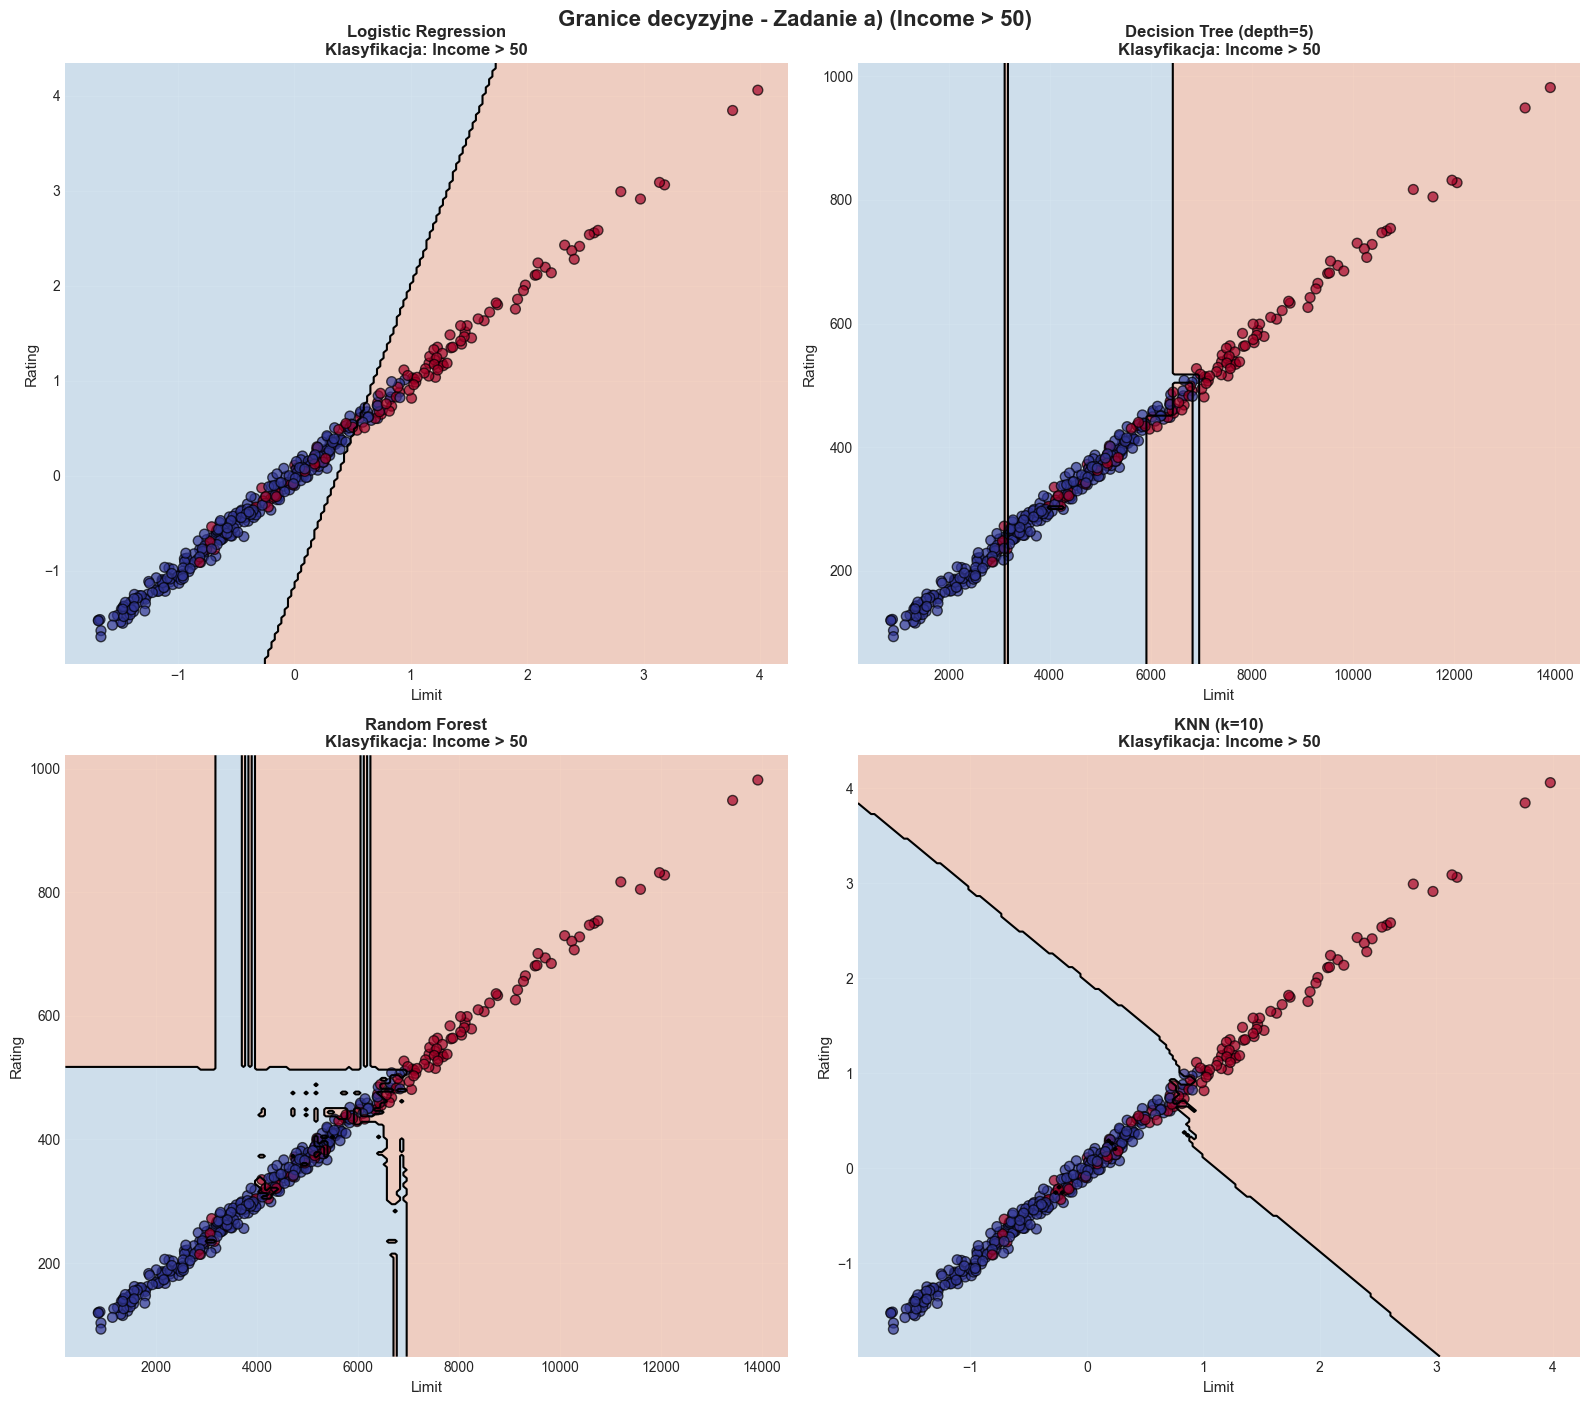


Wizualizacja używa cech: ['Limit', 'Rating']
Czerwony = Income ≤ 50, Niebieski = Income > 50


In [18]:
# Przygotowanie danych z dwoma wybranymi cechami dla zadania a)
feature_indices_a = [X_a.columns.get_loc(f) for f in top_features_a]
X_a_2d = X_a.iloc[:, feature_indices_a].values

# Standaryzacja dla modeli, które tego wymagają
scaler_2d_a = StandardScaler()
X_a_2d_scaled = scaler_2d_a.fit_transform(X_a_2d)

# Wybrane modele do wizualizacji
models_to_plot_a = {
    'Logistic Regression': LogisticRegression(C=10, max_iter=1000, random_state=42),
    'Decision Tree (depth=5)': DecisionTreeClassifier(max_depth=5, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42),
    'KNN (k=10)': KNeighborsClassifier(n_neighbors=10)
}

# Wizualizacja granic decyzyjnych
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.ravel()

for idx, (name, model) in enumerate(models_to_plot_a.items()):
    # Logistic Regression i KNN potrzebują standaryzowanych danych
    if 'Logistic' in name or 'KNN' in name:
        X_train = X_a_2d_scaled
    else:
        X_train = X_a_2d
    
    model.fit(X_train, y_a)
    
    plot_decision_boundary(
        model, X_train, y_a.values, 
        top_features_a, 
        f'{name}\nKlasyfikacja: Income > 50',
        is_classification=True,
        ax=axes[idx]
    )

plt.tight_layout()
plt.suptitle('Granice decyzyjne - Zadanie a) (Income > 50)', 
             fontsize=16, fontweight='bold', y=1.00)
plt.show()

print(f"\nWizualizacja używa cech: {top_features_a}")
print("Czerwony = Income ≤ 50, Niebieski = Income > 50")

### 7.4. Zadanie b) - Granice decyzyjne dla regresji/klasyfikacji wieloklasowej (liczba kart)

Dla zadania b) traktujemy problem jako **klasyfikację wieloklasową** (1-9 kart kredytowych). Każda klasa ma swój kolor, co pozwala zobaczyć, jak modele dzielą przestrzeń cech na regiony odpowiadające różnej liczbie kart.

Rysowanie granic decyzyjnych dla problemu regresji/wieloklasowej klasyfikacji...
Liczba unikalnych klas (liczba kart): [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9)]


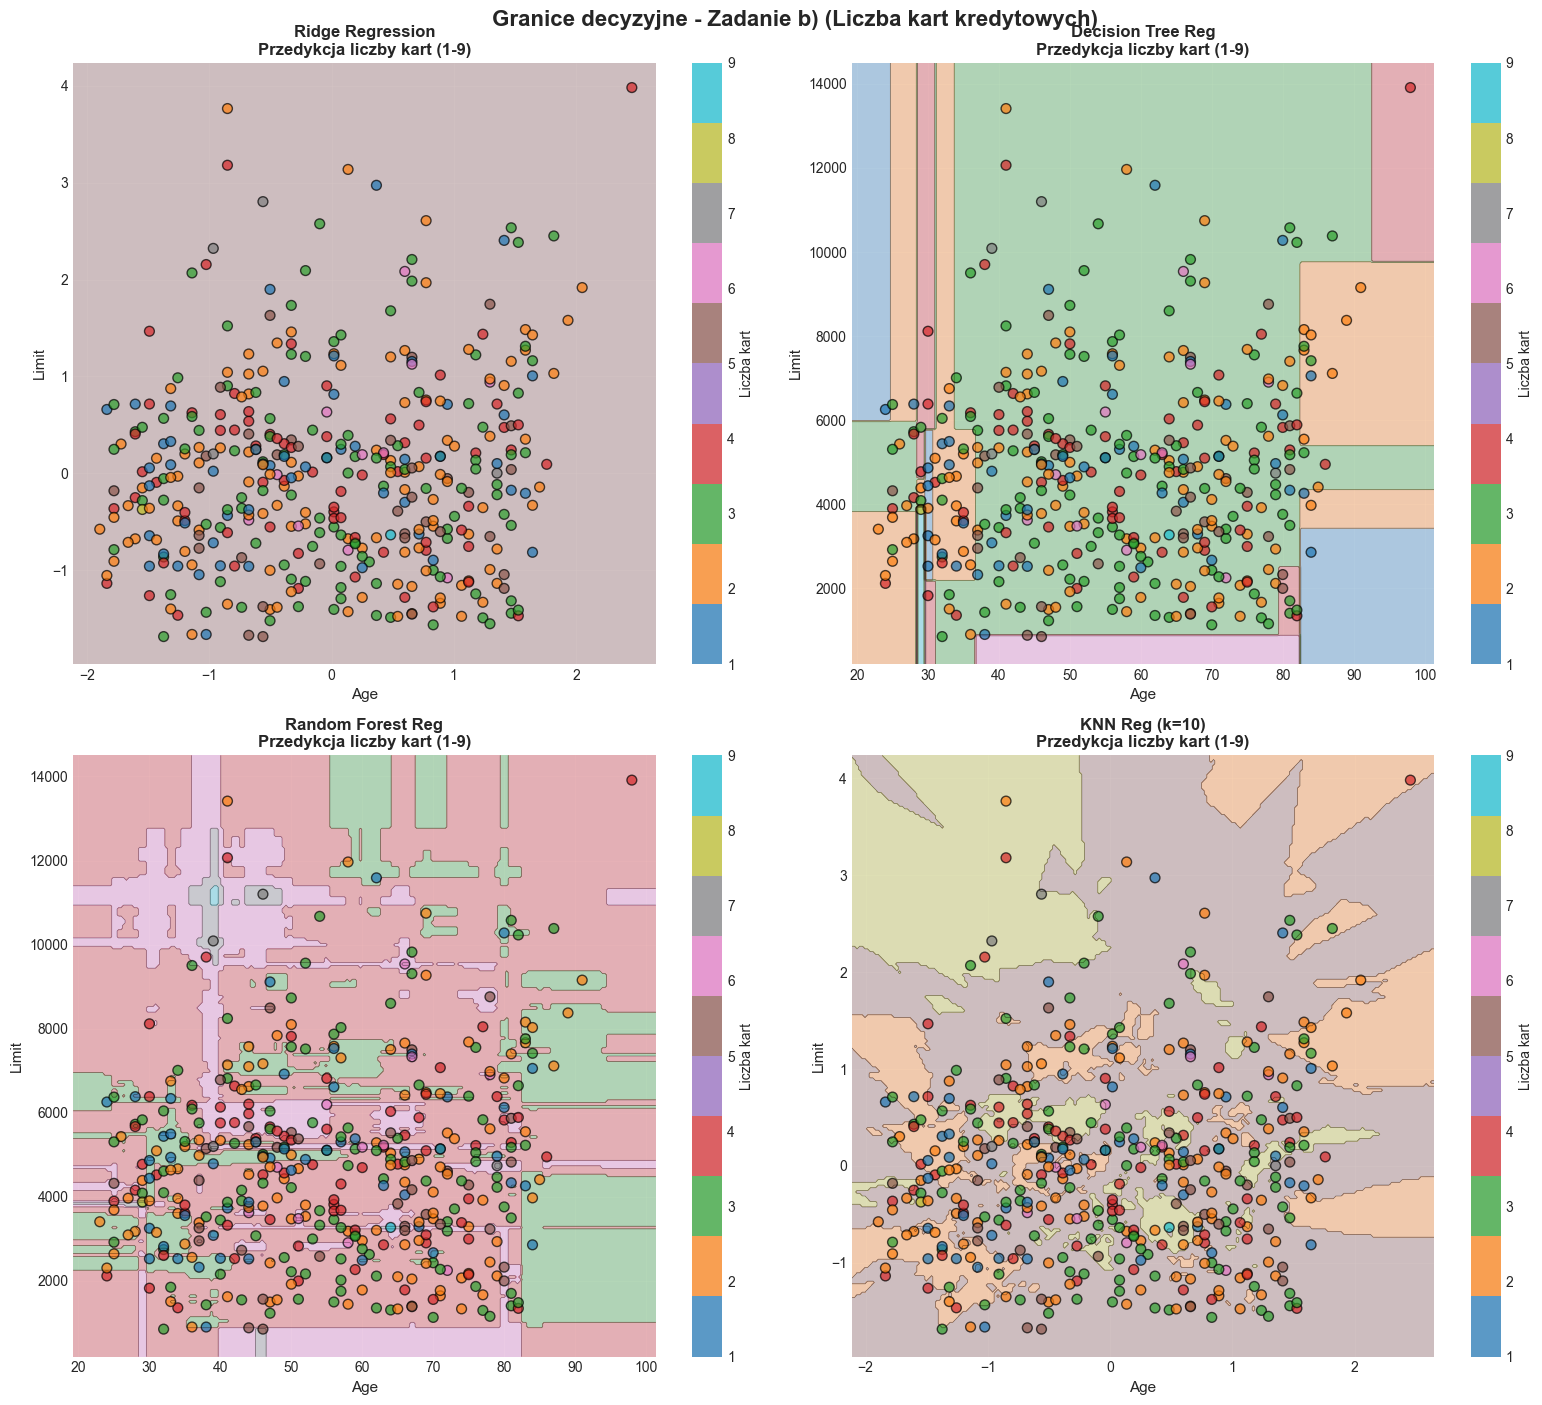


Wizualizacja używa cech: ['Age', 'Limit']
Każdy kolor reprezentuje inną liczbę kart (1-9)

Rozkład klas w danych:
Cards
1     51
2    115
3    111
4     72
5     34
6     11
7      4
8      1
9      1
Name: count, dtype: int64


In [19]:
# Przygotowanie danych z dwoma wybranymi cechami dla zadania b)
feature_indices_b = [X_b.columns.get_loc(f) for f in top_features_b]
X_b_2d = X_b.iloc[:, feature_indices_b].values

# Standaryzacja
scaler_2d_b = StandardScaler()
X_b_2d_scaled = scaler_2d_b.fit_transform(X_b_2d)

# Dla regresji - będziemy zaokrąglać wyniki do całkowitych liczb kart
# Modele regresyjne
models_to_plot_b_reg = {
    'Ridge Regression': Ridge(alpha=0.1, random_state=42),
    'Decision Tree Reg': DecisionTreeRegressor(max_depth=5, random_state=42),
    'Random Forest Reg': RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
    'KNN Reg (k=10)': KNeighborsRegressor(n_neighbors=10)
}

fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.ravel()

print("Rysowanie granic decyzyjnych dla problemu regresji/wieloklasowej klasyfikacji...")
print(f"Liczba unikalnych klas (liczba kart): {sorted(y_b.unique())}")

for idx, (name, model) in enumerate(models_to_plot_b_reg.items()):
    # Ridge i KNN potrzebują standaryzowanych danych
    if 'Ridge' in name or 'KNN' in name:
        X_train = X_b_2d_scaled
    else:
        X_train = X_b_2d
    
    model.fit(X_train, y_b)
    
    plot_decision_boundary(
        model, X_train, y_b.values, 
        top_features_b, 
        f'{name}\nPrzedykcja liczby kart (1-9)',
        is_classification=False,
        ax=axes[idx]
    )

plt.tight_layout()
plt.suptitle('Granice decyzyjne - Zadanie b) (Liczba kart kredytowych)', 
             fontsize=16, fontweight='bold', y=1.00)
plt.show()

print(f"\nWizualizacja używa cech: {top_features_b}")
print("Każdy kolor reprezentuje inną liczbę kart (1-9)")
print("\nRozkład klas w danych:")
print(y_b.value_counts().sort_index())

### 7.5. Analiza i wnioski dotyczące granic decyzyjnych

**Zadanie a) - Klasyfikacja binarna (Income > 50):**
- Granice decyzyjne są wyraźne i intuicyjne
- Regresja logistyczna tworzy liniową granicę decyzyjną
- Drzewa decyzyjne tworzą prostokątne regiony (axis-aligned splits)
- Random Forest i KNN tworzą bardziej złożone, nieliniowe granice

**Zadanie b) - Problem wieloklasowy (liczba kart):**
- Każdy kolor reprezentuje różną liczbę kart (1-9)
- Granice są bardziej skomplikowane ze względu na 9 klas
- Problem jest trudniejszy - widać duże nakładanie się klas
- Modele próbują znaleźć wzorce, ale dane są mocno przemieszane
- Niektóre klasy (np. 7, 8, 9 kart) są bardzo rzadkie, co utrudnia ich przewidywanie

**Czy sensowne granice dla zadania b)?**
- **Częściowo tak** - modele znajdują pewne wzorce (np. osoby z wyższym Rating/Limit częściej mają więcej kart)
- **Ale problem jest trudny** ze względu na:
  - Dużą liczbę klas (9)
  - Niezbalansowanie klas (większość ma 2-4 karty)
  - Nakładanie się rozkładów cech między klasami
- Granice są bardziej rozmyte niż w zadaniu a), co tłumaczy niższą accuracy (~34% vs ~96%)

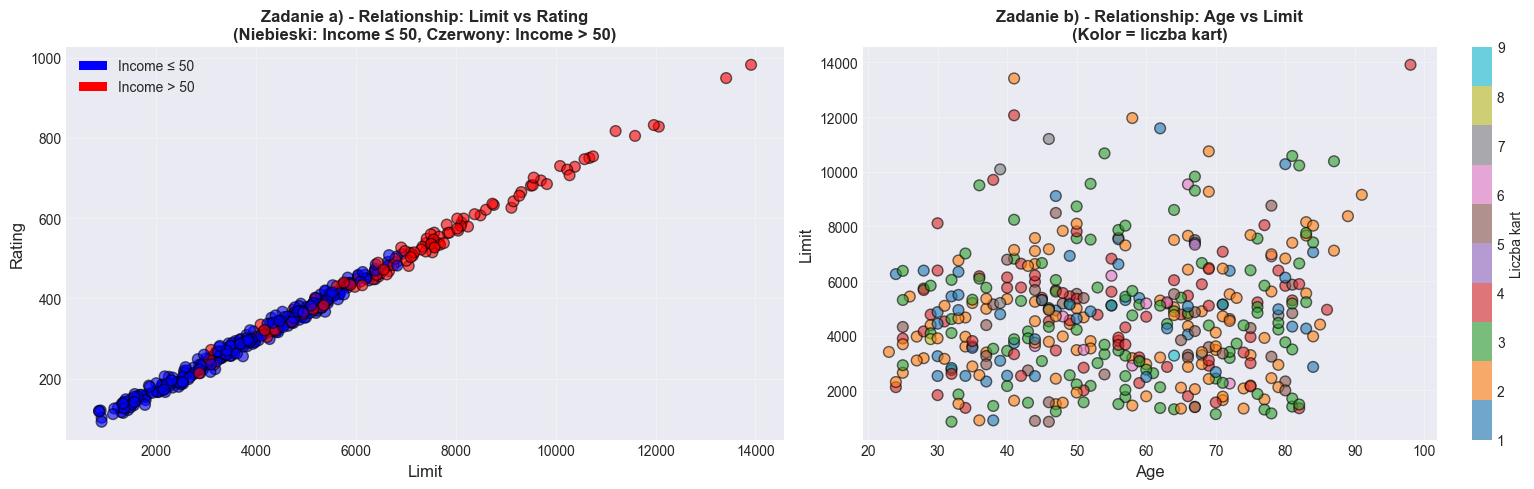


Obserwacje:
----------------------------------------------------------------------
ZADANIE A):
  • Wyraźna separacja między klasami wzdłuż linii Limit/Rating
  • Osoby z wyższym Limit i Rating częściej mają Income > 50
  • Granice decyzyjne są sensowne i dobrze separują klasy

ZADANIE B):
  • Brak wyraźnej separacji między klasami - duże nakładanie
  • Większość osób ma 2-4 karty (rozkład mocno skoncentrowany)
  • Osoby starsze i z wyższym Limit mają tendencję do więcej kart
  • Rzadkie klasy (7-9 kart) bardzo trudne do przewidzenia
  • Granice decyzyjne są rozmyte - stąd niska accuracy (~34%)


In [20]:
# Dodatkowa analiza - korelacja wybranych cech z zmiennymi docelowymi
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Zadanie a) - scatter plot
colors_a = ['blue' if x == 0 else 'red' for x in y_a]
axes[0].scatter(df['Limit'], df['Rating'], c=colors_a, alpha=0.6, edgecolors='black', s=60)
axes[0].set_xlabel('Limit', fontsize=12)
axes[0].set_ylabel('Rating', fontsize=12)
axes[0].set_title('Zadanie a) - Relationship: Limit vs Rating\n(Niebieski: Income ≤ 50, Czerwony: Income > 50)', 
                  fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Dodanie legendy
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='blue', label='Income ≤ 50'),
                   Patch(facecolor='red', label='Income > 50')]
axes[0].legend(handles=legend_elements, loc='upper left')

# Zadanie b) - scatter plot z kolorami dla liczby kart
scatter_b = axes[1].scatter(df['Age'], df['Limit'], c=y_b, cmap='tab10', 
                            alpha=0.6, edgecolors='black', s=60, vmin=1, vmax=9)
axes[1].set_xlabel('Age', fontsize=12)
axes[1].set_ylabel('Limit', fontsize=12)
axes[1].set_title('Zadanie b) - Relationship: Age vs Limit\n(Kolor = liczba kart)', 
                  fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)
plt.colorbar(scatter_b, ax=axes[1], label='Liczba kart', ticks=range(1, 10))

plt.tight_layout()
plt.show()

print("\nObserwacje:")
print("-" * 70)
print("ZADANIE A):")
print("  • Wyraźna separacja między klasami wzdłuż linii Limit/Rating")
print("  • Osoby z wyższym Limit i Rating częściej mają Income > 50")
print("  • Granice decyzyjne są sensowne i dobrze separują klasy")
print("\nZADANIE B):")
print("  • Brak wyraźnej separacji między klasami - duże nakładanie")
print("  • Większość osób ma 2-4 karty (rozkład mocno skoncentrowany)")
print("  • Osoby starsze i z wyższym Limit mają tendencję do więcej kart")
print("  • Rzadkie klasy (7-9 kart) bardzo trudne do przewidzenia")
print("  • Granice decyzyjne są rozmyte - stąd niska accuracy (~34%)")

## 8. Podsumowanie końcowe

### Odpowiedzi na pytania badawcze:

**1. Najlepsze modele i ich accuracy:**

**Zadanie a) Klasyfikacja (Income > 50):**
- 🏆 **Logistic Regression (C=10): 96.25%** ± 3.75%
- Bardzo wysoka skuteczność dzięki wyraźnej separacji liniowej między klasami
- Predyktory Limit i Rating tworzą naturalną granicę decyzyjną

**Zadanie b) Regresja (liczba kart):**
- 🏆 **Ridge Regression (alpha=0.1): 34.00%** ± 5.15%
- Znacznie niższa skuteczność z powodu:
  - 9 klas do przewidzenia (zamiast 2)
  - Silne niezbalansowanie (większość ma 2-4 karty)
  - Duże nakładanie się rozkładów cech między klasami

**2. Sensowność granic decyzyjnych dla zadania b):**

✅ **Tak, ale z zastrzeżeniami:**
- Modele znajdują pewne wzorce (Age, Limit korelują z liczbą kart)
- Granice są **bardziej rozmyte** niż w zadaniu a)
- Przewidywanie dokładnej liczby kart jest trudne, ale modele mogą wskazać tendencję
- **Najlepsze zastosowanie**: grupowanie do kategorii (np. "mało kart", "średnio", "dużo") zamiast dokładnej liczby
- Rzadkie klasy (7-9 kart) praktycznie niemożliwe do przewidzenia z 2 cechami

**3. Kluczowe wnioski:**
- Walidacja krzyżowa (10-fold) zapewniła wiarygodną ocenę
- Box-ploty ujawniły stabilność modeli
- Wizualizacja granic decyzyjnych pokazała, dlaczego zadanie a) jest znacznie łatwiejsze
- Problem wieloklasowy z niezbalansowanymi danymi wymaga innych technik (SMOTE, grupowanie klas)